# Quantum Approximate Optimisation Algorithm for Solving the Max-Cut Problem


<div class="alert alert-block alert-warning">

Your task is to fill all the gaps in the code marked <b>TODO</b>.

</div>


In [1]:
# Install all the necessary libraries
%pip install --quiet qiskit==1.1.0 qiskit_aer==0.14.2 networkx==3.3 pylatexenc==2.10

Note: you may need to restart the kernel to use updated packages.


<div class="alert alert-block alert-info">
<b> Task 1: </b> <br>
Use the NetworkX library to prepare an <strong>undirected connected graph</strong> (a graph where all vertices are connected by edges, ensuring a path exists between any two vertices) that:

- contains 4 vertices;
- the numbering of the vertices is $0, ..., 3$;
- the connections between the vertices are arbitrary;
- edges have no weights.


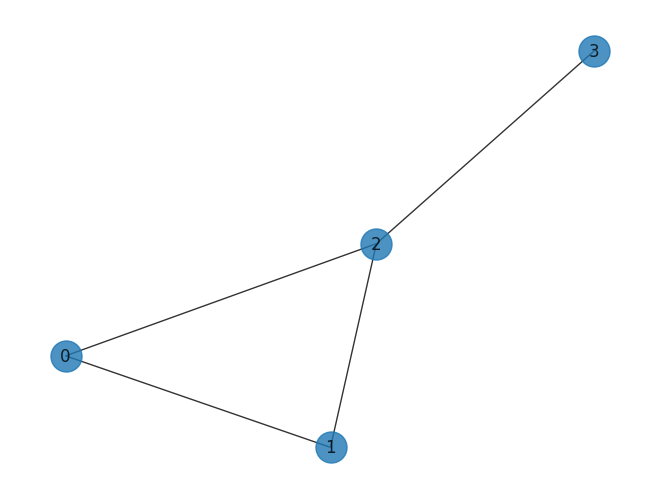

In [6]:
import networkx as nx

# Create a graph
graph = nx.Graph()
graph.add_nodes_from([0, 1, 2, 3])
graph.add_edges_from([(0, 1), (1, 2), (2, 3), (0, 2)])

# Display the graph
nx.draw(graph, with_labels=True, alpha=0.8, node_size=500)

assert nx.is_connected(graph) == True, "The graph has to be connected!"

In [8]:
# This function finds the solution using a purely classical solver (a reference method)
def get_classical_solution(graph):
    """Args:
        graph: networkx graph
    Returns:
        max_cut_value: (int) the value of maximum cut
        sets: (tuple[set[int], set[int]]) the split of the vertices into two sets
        result_in_binary: (str) binary encoding of the result
    """
    max_cut_value, sets = nx.algorithms.approximation.one_exchange(graph)
    result_in_binary = ""
    for i in range(len(graph.nodes())):
        if i in sets[0]:
            result_in_binary += "0"  # if the node is in the first set mark it as "0"
        else:
            result_in_binary += "1"  # otherwise mark it as "1"
    return max_cut_value, sets, result_in_binary

In [9]:
classical_solution = get_classical_solution(graph)
print(
    f"""The value of the maximum cut is: {classical_solution[0]}.
The nodes are divided into the following sets: {classical_solution[1]}.
The result encoded in binary is: {classical_solution[2]}."""
)

The value of the maximum cut is: 3.
The nodes are divided into the following sets: ({2}, {0, 1, 3}).
The result encoded in binary is: 1101.


<div class="alert alert-block alert-info">

<b>Task 2: </b> <br>

Implement the following cost function $C$ that converts a binary string $\boldsymbol{x}$ "$x_0 x_1 \dots x_{n-1}$" into the cost function value, $E$ is the set of edges: $$C(\boldsymbol{x}) = \sum_{(i,j) \in E} (-x_i -x_j + 2x_ix_j)$$

<br> <b>Note:</b> Since the QAOA is a minimalisation algorithm, and the problem is a maximization problem (<b>Max</b>-Cut), the cost function presented above is multiplied by -1 multiply compared to the formula in the lecture notes.

</div>


In [10]:
def maxcut_cost_function(x, graph):
    """Args:
        x: (str) a binary string representing the assigment of vertices
        graph: networkx graph
    Returns:
        obj: (float) cost function value
    """
    cost_value = 0
    for i, j in graph.edges():
        xi = int(x[i])
        xj = int(x[j])
        edge_cost = -xi - xj + 2 * xi * xj
        cost_value += edge_cost
    return cost_value

In [12]:
# If the function is implemented incorrectly, the assert below will return an error
assert (
    maxcut_cost_function(classical_solution[2], graph) == -classical_solution[0]
), "The function maxcut_obj is not correctly implemented"

## THE QUANTUM PART OF THE ALGORITHM

Represent the optimisation problem as a parameterized quantum circuit.


<div class="alert alert-block alert-info">
<b>Task 3: </b> <br>
Implement the QAOA circuit

1. Create a quantum circuit with $n$ qubits, where $n$ is the number of vertices in the graph.
2. Add a Hadamard gate on each of the qubits.
3. Add the part of the circuit representing the cost Hamiltonian:

   1. If an edge exists between the vertices $v_i$ and $v_j$ ($i<j$) then apply the following gate sequence:

   <img src="https://i.imgur.com/hO54hXD.png" title="Sequence of gates encoding the cost hamiltonian" width="350"/>

   2. (Optional) Add a barrier after the above sequence of gates to make the circuit visualization easier to read.
   3. Repeat this gate sequence for all edges in the graph.

4. Create the part of the circuit representing the mixing Hamiltonian:

   1. Apply the following gate on each of the qubits:

   <img src="https://imgur.com/5X03a16.png" title="Sequence of gates encoding the cost hamiltonian" width="350"/>

5. Add a measurement on each qubit.

---

<b>Hint:</b> Example circuit for a Max-Cut problem consisting of 2 vertices:

<img src="https://imgur.com/LgczMGB.png" title="source: imgur.com" />
</div>


In [14]:
from qiskit import QuantumCircuit


# Create the QAOA circuit


def create_qaoa_circuit(graph, angles):
    """Args:
        graph: networkx graph
        theta: (list) unitary parameters
    Returns:
        (QuantumCircuit) qiskit circuit
    """
    assert len(angles) % 2 == 0, "The number of angles should be even"

    p = len(angles) // 2
    gammas = angles[0::2]
    betas = angles[1::2]

    # 3.1 Create a quantum circuit
    nqubits = len(graph.nodes)
    quantum_circuit = QuantumCircuit(nqubits)

    # 3.2 Add Hadamard gates
    for qubit in range(nqubits):
        quantum_circuit.h(qubit)

    for layer_index in range(p):
        # 3.3 Add the gate sequence representing the cost Hamiltonian
        for i, j in graph.edges():
            if i < j:
                quantum_circuit.cz(i, j)
                quantum_circuit.rz(gammas[layer_index], i)
                quantum_circuit.rz(gammas[layer_index], j)

        quantum_circuit.barrier()

        # 3.4 Add the gate representing the mixer Hamiltonian
        for qubit in range(nqubits):
            quantum_circuit.rx(2 * betas[layer_index], qubit)

    # 3.5 Measure all qubits
    quantum_circuit.measure_all()

    return quantum_circuit

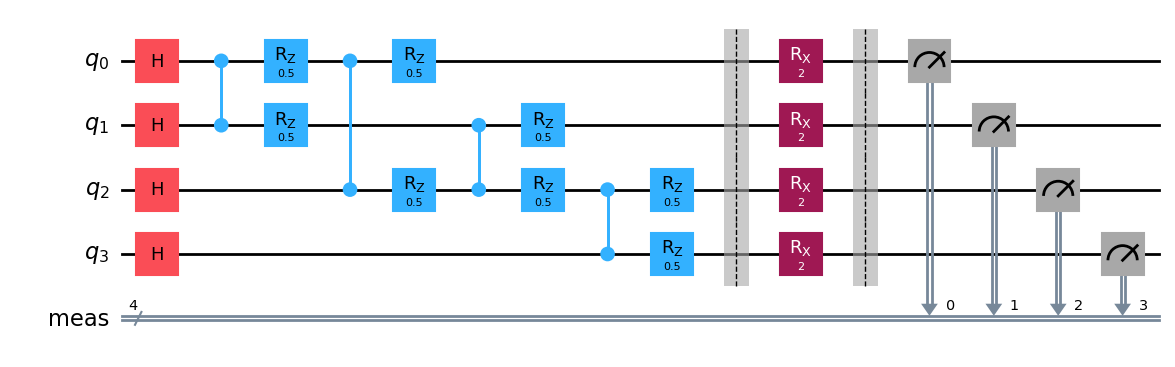

In [15]:
# This code creates the QAOA circuit for the graph to verify the correct application of gates
angles = [0.5, 1.0]  # gamma_1, beta_1
create_qaoa_circuit(graph, angles).draw(output="mpl")

In [16]:
# Below we have functions that calculate how ‘good’ the angles are
# based on measurements from the quantum circuit.
# The closer the expectation value to the negated correct result the better.

from qiskit_aer import Aer


# This function calculates the expectation value of the results
def compute_expectation(counts, graph):
    """Args:
        counts: (dict) key as bit string, val as count
        graph: networkx graph
    Returns:
        avg: (float) expectation value
    """
    avg = 0
    sum_count = 0
    for bit_string, count in counts.items():
        obj = maxcut_cost_function(
            bit_string[::-1], graph
        )  # the bit-string needs to be reversed due
        # to the way that Qiskit returns the results
        avg += obj * count
        sum_count += count
    return avg / sum_count


# This function executes the circuit on the chosen backend
def get_expectation(graph, shots=512):
    """Args:
    graph: networkx graph
    """
    backend = Aer.get_backend("qasm_simulator")
    backend.shots = shots

    def execute_circuit(angles):
        qc = create_qaoa_circuit(graph, angles)
        counts = backend.run(qc, seed_simulator=10, nshots=512).result().get_counts()
        return compute_expectation(counts, graph)

    return execute_circuit

## THE CLASSICAL PART OF THE ALGORITHM

Use a classical optimiser to optimise the initial values of the <b>$\gamma$</b> and <b>$\beta$</b> angles to solve the Max-Cut problem.


<div class="alert alert-block alert-info">
<b>Task 4: </b> <br>

Try to optimise the values of the parameterised quantum gates (angles) to get the best results.

1. Set a classical optimization method chosen from <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html" title="SciPy minimize">SciPy minimize</a> and compare the number of correct results obtained when increasing the depth $p$ of the quantum circuit.

   1. $p=1: [\gamma_1, \beta_1]$;
   2. $p=5: [\gamma_1, \beta_1, \dots, \gamma_5, \beta_5]$;
   3. $p=10: [\gamma_1, \beta_1, \dots, \gamma_{10}, \beta_{10}]$.

   <b>Note:</b> If you are going to use a random number generator, set a seed to get reproducible results.

2. Choose a different classical optimisation method from <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html" title="SciPy minimize">SciPy minimize</a> than in task 4.1 and compare its results for $p=10$ with the results from the subtask 4.1.C. Does the choice of classical optimizer affect the number of correct results?


In [21]:
import random
import numpy as np
from scipy.optimize import minimize

np.random.seed(37)
p_values = [1, 5, 10]
results = {}

for p in p_values:
    angles = np.random.rand(2 * p)
    method = "COBYLA"

    print(f"Initial angles for p={p}: {angles}")
    result = minimize(get_expectation(graph), angles, method=method)
    results[p] = result
    print(f"Optimization result for p={p} using {method}:", result)

expectation = get_expectation(graph)
method = "BFGS"
angles = np.random.rand(2 * 10)

print(f"initial angles: {angles}")
result = minimize(expectation, angles, method=method)
print(result)

Initial angles for p=1: [0.417022   0.72032449]
Optimization result for p=1 using COBYLA:  message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.1357421875
       x: [ 8.498e-01  1.386e+00]
    nfev: 30
   maxcv: 0.0
Initial angles for p=5: [1.14374817e-04 3.02332573e-01 1.46755891e-01 9.23385948e-02
 1.86260211e-01 3.45560727e-01 3.96767474e-01 5.38816734e-01
 4.19194514e-01 6.85219500e-01]
Optimization result for p=5 using COBYLA:  message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.6845703125
       x: [-7.007e-04  1.583e+00  1.204e+00 -3.133e-01 -2.702e-02
            1.487e+00 -2.438e-01  4.540e-01  2.484e-01  3.991e-01]
    nfev: 116
   maxcv: 0.0
Initial angles for p=10: [0.20445225 0.87811744 0.02738759 0.67046751 0.4173048  0.55868983
 0.14038694 0.19810149 0.80074457 0.96826158 0.31342418 0.69232262
 0.87638915 0.89460666 0.08504421 0.03905478 0.16983042 0.8781425
 0.09834683 0.42110763]
Optimization result f

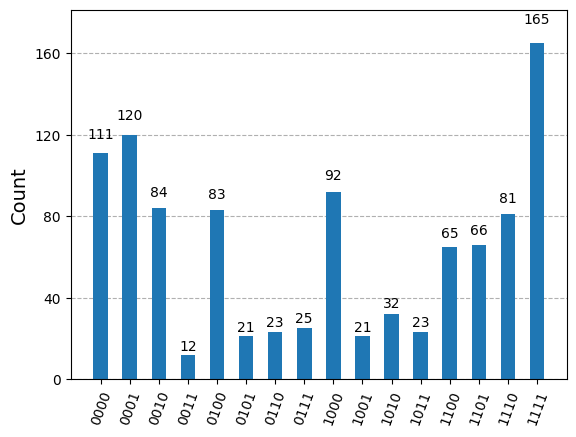

In [18]:
# Visualize the results
backend = Aer.get_backend("aer_simulator")
backend.shots = 512

from qiskit.visualization import plot_histogram

qaoa_circuit = create_qaoa_circuit(graph, result.x)
counts = backend.run(qaoa_circuit, seed_simulator=42).result().get_counts()
plot_histogram(counts)